In [1]:
from diffusers import DDPMPipeline

/home/computerman/Desktop/Diffusors/diffVenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 25/25 [00:01<00:00, 14.36it/s]


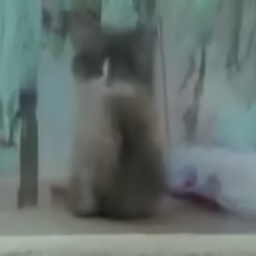

In [2]:

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

image = ddpm(num_inference_steps=25).images[0]

image

In [3]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [4]:
scheduler.set_timesteps(50)
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [5]:
import torch

sample_size = model.config.sample_size

noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
print(sample_size)
print(noise.shape)

256
torch.Size([1, 3, 256, 256])


In [12]:
input = noise

for t in scheduler.timesteps:

    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

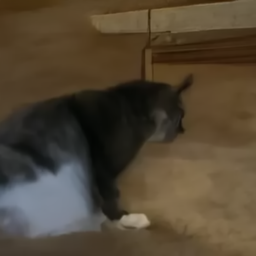

In [13]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

100%|██████████| 50/50 [00:03<00:00, 15.52it/s]


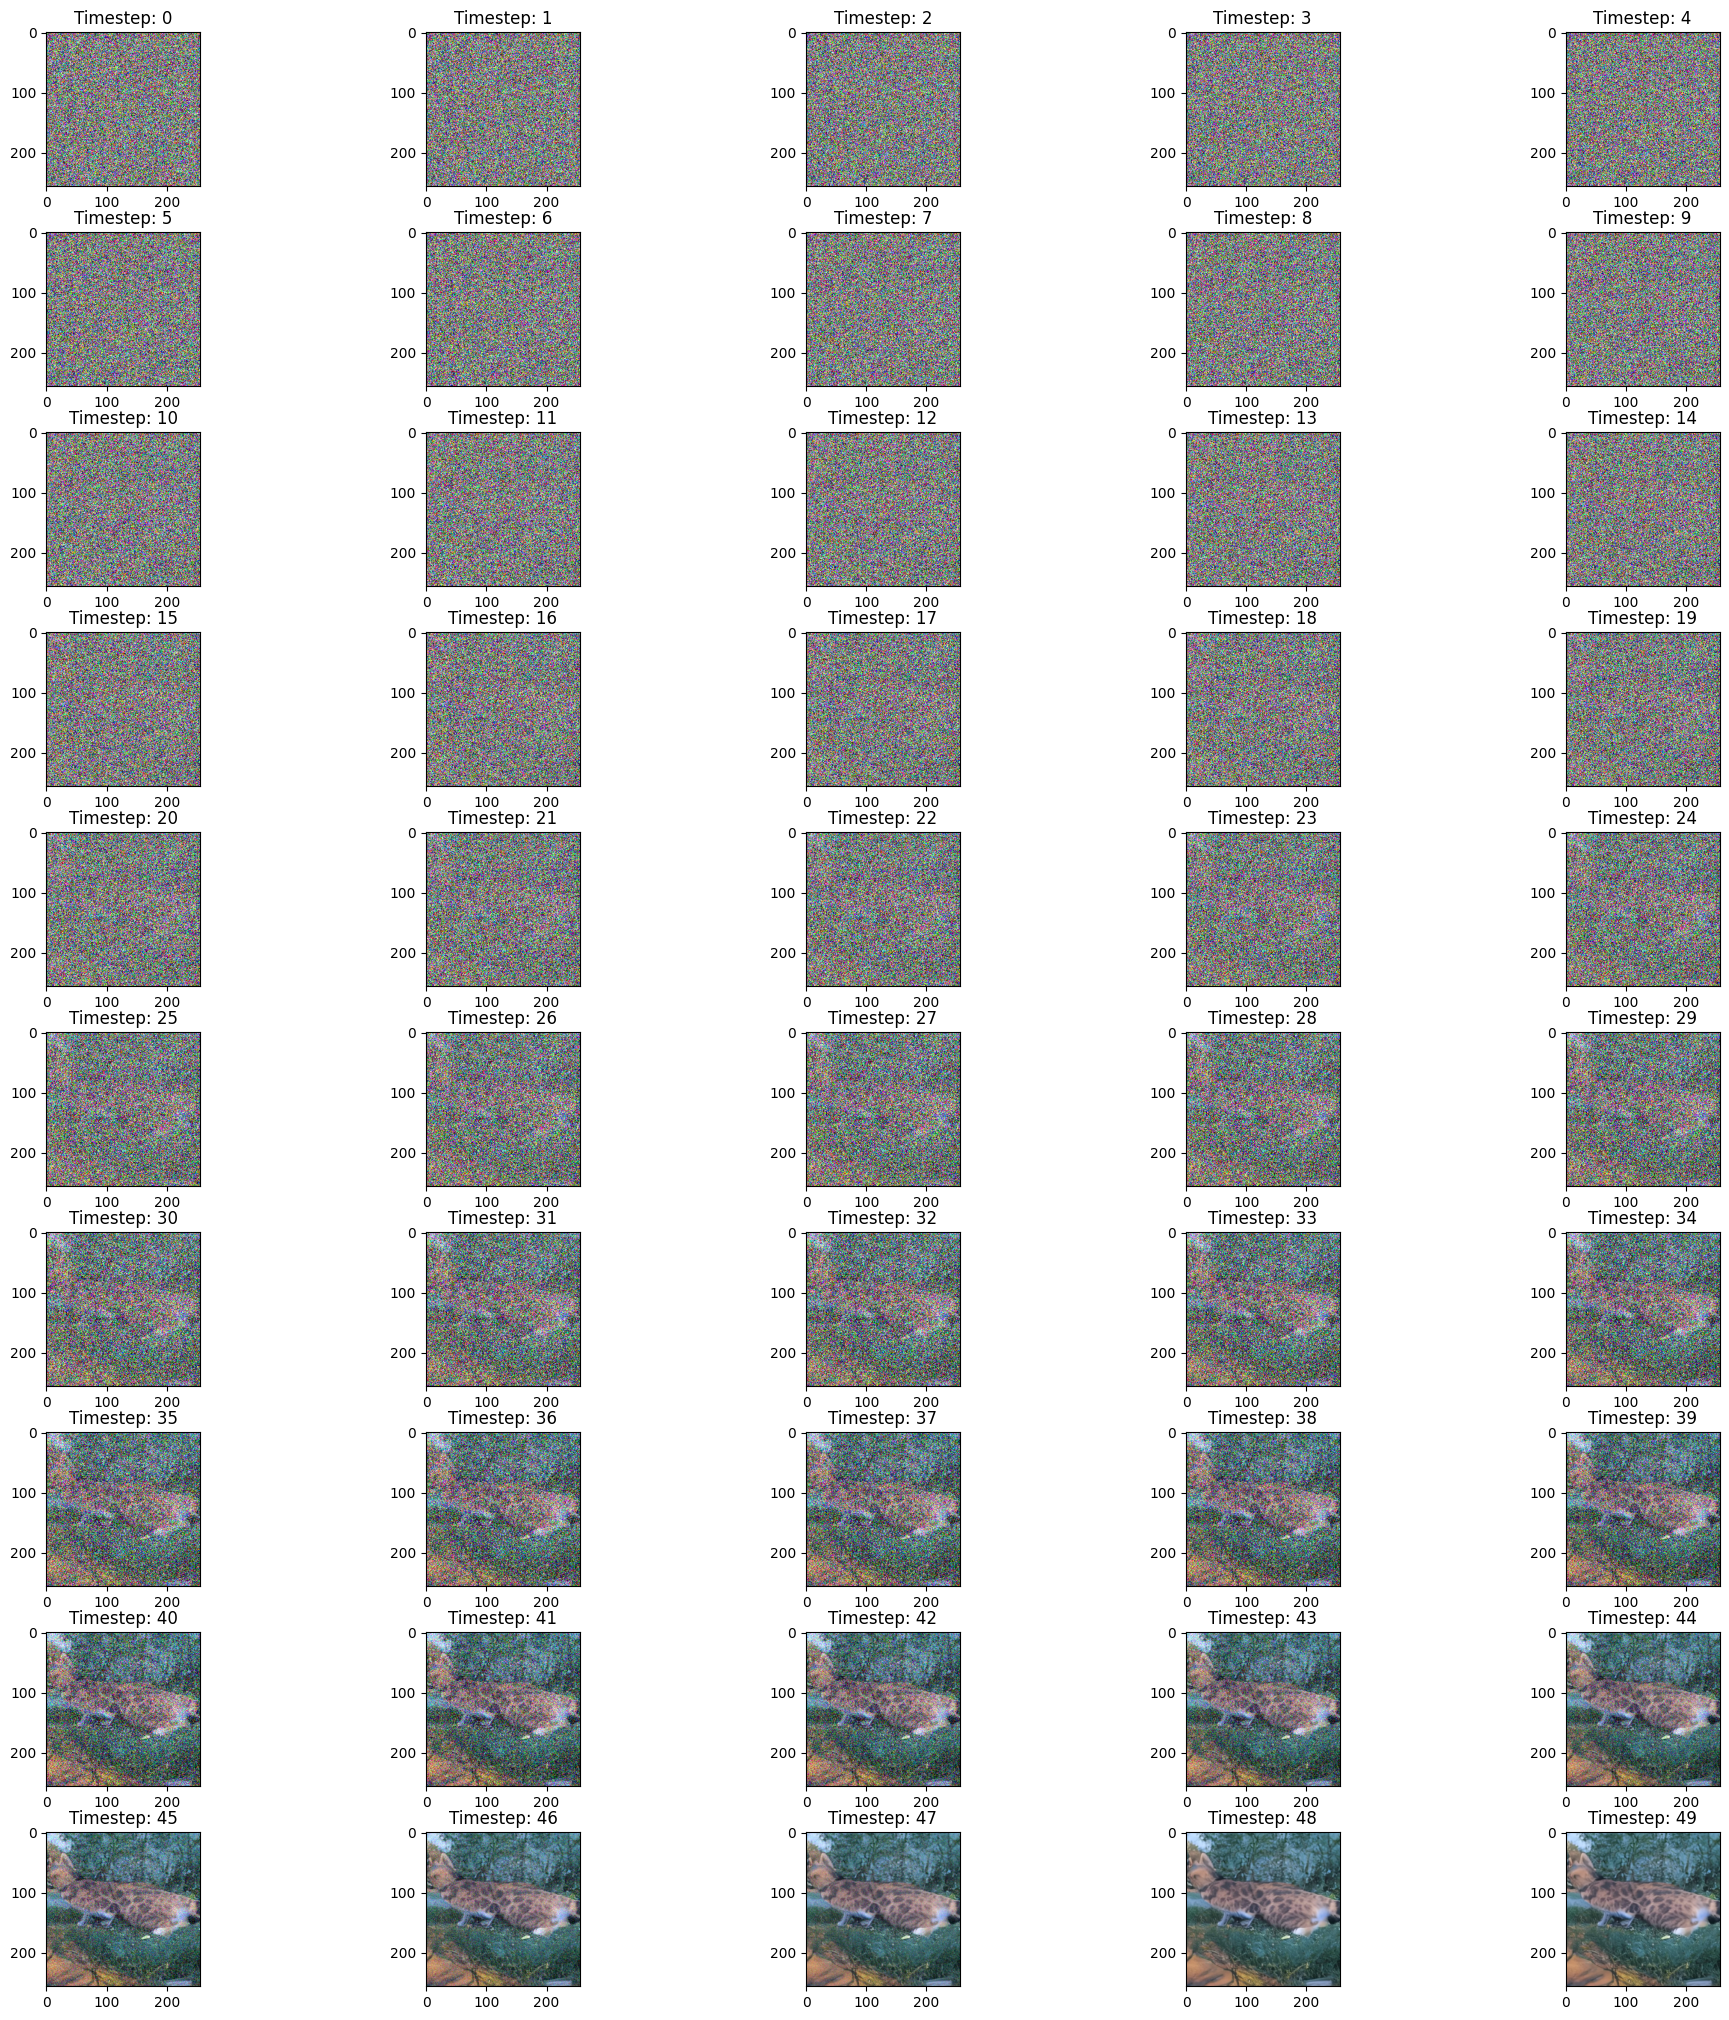

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm

input = noise
num_images = len(scheduler.timesteps)
num_cols = 5  # You can adjust this value
num_rows = num_images // num_cols if num_images % num_cols == 0 else num_images // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))  # You can adjust the figure size

# Wrap scheduler.timesteps with tqdm()
for i, t in enumerate(tqdm(scheduler.timesteps)):
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

    # Convert the tensor to an image
    image = (input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)

    # Display the image
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(image)
    axs[row, col].set_title(f'Timestep: {i}')  # Add timestep to the plot label

plt.tight_layout(pad=0)
plt.show()

In [20]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import UniPCMultistepScheduler

In [21]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)

tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")

text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True)

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True)

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [22]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320

In [23]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [24]:
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [29]:
print(text_input)

{'input_ids': tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}


In [43]:
print(text_embeddings.shape)
print(text_embeddings[0][0].shape)

torch.Size([1, 77, 768])
torch.Size([768])


In [57]:
print(text_embeddings[0][29])

tensor([-3.1083e+00,  4.9518e-02, -1.3673e-01,  6.5570e-01, -2.5335e+00,
         1.1738e+00, -1.7992e+00,  1.2020e+00,  6.4172e-01, -2.9278e-01,
        -2.5350e-01,  1.2887e-01,  2.1039e-01,  5.3727e-01,  7.1451e-01,
         5.0390e-01, -7.3762e-01, -3.2141e-01,  2.1227e-01,  2.1862e+00,
         1.4409e-01,  4.1745e-01, -2.1411e+00,  1.5407e+00, -1.5977e+00,
        -3.3655e-01,  3.3958e-01, -1.5924e+00, -3.1879e-01, -2.2197e-01,
         7.8871e-01, -3.8670e-01, -2.6860e-01, -1.5441e-01, -4.8438e-01,
         2.0483e-01, -1.7647e-02,  7.2983e-02,  1.2354e+00, -2.0636e+00,
         5.1798e-01, -4.8146e-01, -8.8598e-01, -9.9079e-01, -2.3457e+00,
        -1.1271e+00, -1.5143e+00,  5.9862e-01, -7.9263e-01, -5.6841e-02,
         5.8858e-01,  9.4681e-01,  4.8402e-01,  2.3168e+00, -5.6556e-01,
        -1.0449e+00,  6.7166e-01,  5.3559e-01,  5.3772e-01, -8.8248e-01,
         5.7309e-01, -1.7077e+00,  9.2303e-03, -1.1974e-01,  2.6225e-02,
         3.8048e-01,  2.5282e-01,  1.9847e+00, -1.7

Each embedding changes. Even for the same token values. However different token values result in VERY SIMILAR embeddings. My guess is that they are slightly different due to the position in the sentence.